In [1]:
import IPython.display
import numpy as np
import os
import sys
import seaborn as sns

import matplotlib.pyplot as plt

ROOT_DIR = os.path.abspath("../")
sys.path.append(ROOT_DIR)

from utils.log_progress import *
from utils.tools import *
from utils.config import *
from utils.utils import *

from unet.unet import *
from unet.data_generator import *

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
def display_weight_stats(model):
    """Scans all the weights in the model and returns a list of tuples
    that contain stats about each weight.
    """
    layers = model.layers
    table = [["WEIGHT NAME", "SHAPE", "MIN", "MAX", "STD"]]
    for l in layers:
        weight_values = l.get_weights()  # list of Numpy arrays
        weight_tensors = l.weights  # list of TF tensors
        for i, w in enumerate(weight_values):
            weight_name = weight_tensors[i].name
            # Detect problematic layers. Exclude biases of conv layers.
            alert = ""
            if w.min() == w.max() and not (l.__class__.__name__ == "Conv2D" and i == 1):
                alert += "<span style='color:red'>*** dead?</span>"
            if np.abs(w.min()) > 1000 or np.abs(w.max()) > 1000:
                alert += "<span style='color:red'>*** Overflow?</span>"
            # Add row
            table.append([
                weight_name + alert,
                str(w.shape),
                "{:+9.4f}".format(w.min()),
                "{:+10.4f}".format(w.max()),
                "{:+9.4f}".format(w.std()),
            ])
    display_table(table)
    
def display_table(table):
    """Display values in a table format.
    table: an iterable of rows, and each row is an iterable of values.
    """
    html = ""
    for row in table:
        row_html = ""
        for col in row:
            row_html += "<td>{:40}</td>".format(str(col))
        html += "<tr>" + row_html + "</tr>"
    html = "<table>" + html + "</table>"
    IPython.display.display(IPython.display.HTML(html))

## Trained Model:

#### load Model:

In [12]:
from keras.models import load_model, model_from_json

model = load_model('../saved_models/model0/model0.h5', custom_objects={'bce_dice_loss': bce_dice_loss,'dice_coeff':dice_coeff,'iou_score':iou_score})

In [13]:
display_weight_stats(model)

WEIGHT NAME,SHAPE,MIN,MAX,STD
block1_conv1_1/kernel:0,"(3, 3, 3, 64)",-0.6598,+0.5493,+0.1922
block1_conv1_1/bias:0,"(64,)",-0.0059,+1.7330,+0.2931
block1_conv2_1/kernel:0,"(3, 3, 64, 64)",-0.2179,+0.2604,+0.0418
block1_conv2_1/bias:0,"(64,)",-0.9569,+0.7667,+0.3051
block2_conv1_1/kernel:0,"(3, 3, 64, 128)",-0.3409,+0.4231,+0.0309
block2_conv1_1/bias:0,"(128,)",-0.1747,+0.3497,+0.1172
block2_conv2_1/kernel:0,"(3, 3, 128, 128)",-0.1938,+0.2451,+0.0233
block2_conv2_1/bias:0,"(128,)",-0.5415,+0.6116,+0.1820
block3_conv1_1/kernel:0,"(3, 3, 128, 256)",-0.1766,+0.5925,+0.0176
block3_conv1_1/bias:0,"(256,)",-0.1778,+0.2312,+0.0655


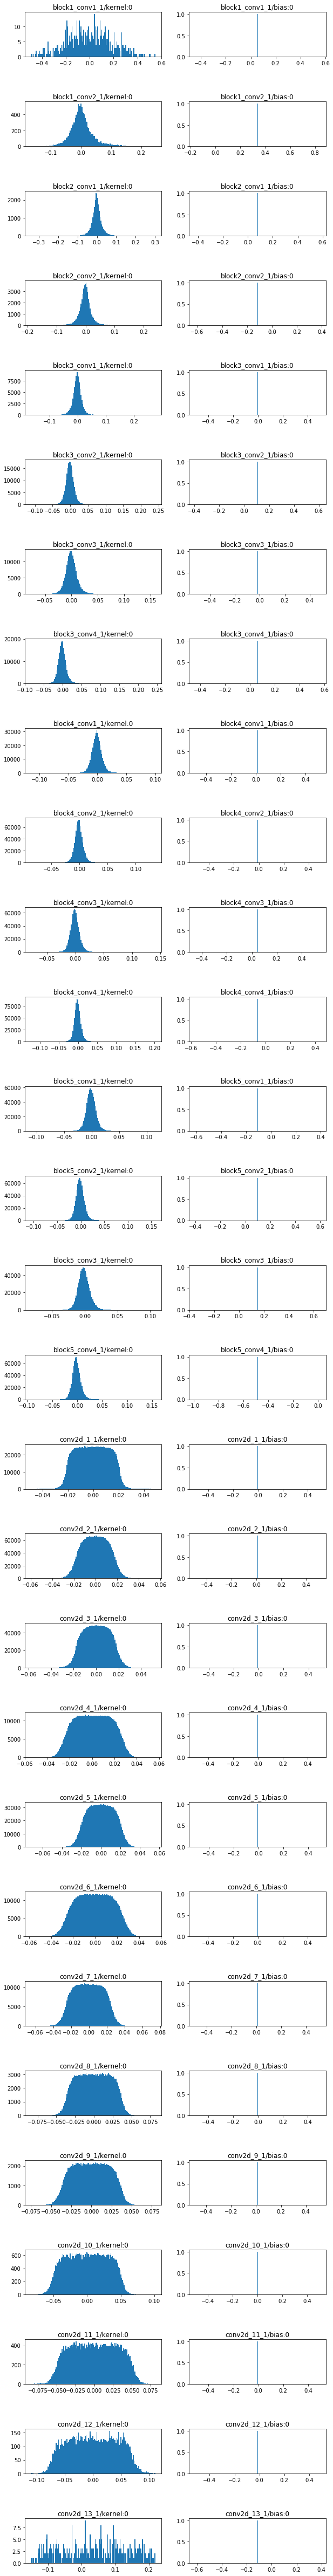

In [14]:
all_weights = []
all_names = []

# Pick layer types to display
LAYER_TYPES = ['Conv2D', 'Dense', 'Conv2DTranspose']
# Get layers
layers = model.layers
layers = list(filter(lambda l: l.__class__.__name__ in LAYER_TYPES, 
                layers))
# Display Histograms
fig, ax = plt.subplots(len(layers), 2, figsize=(10, 3*len(layers)),
                       gridspec_kw={"hspace":1})
for l, layer in enumerate(layers):
    weights = layer.get_weights()
    for w, weight in enumerate(weights):
        tensor = layer.weights[w]
        ax[l, w].set_title(tensor.name)
        _ = ax[l, w].hist(weight[w].flatten(), 150)
        if "bias" not in tensor.name:
            all_weights.append(weight[w].flatten())
            all_names.append(tensor.name[:-9])

In [15]:
df = pd.DataFrame(columns=['layer_name', 'weights_values'])
for n, w in zip(all_names,all_weights):
    if len(w) > 1:
        tmp = pd.DataFrame({"layer_name":[n for i in range(len(w.flatten()))], 
                            "weights_values":w.flatten()}) 
        df = df.append(tmp)

[(-0.2, 0.2)]

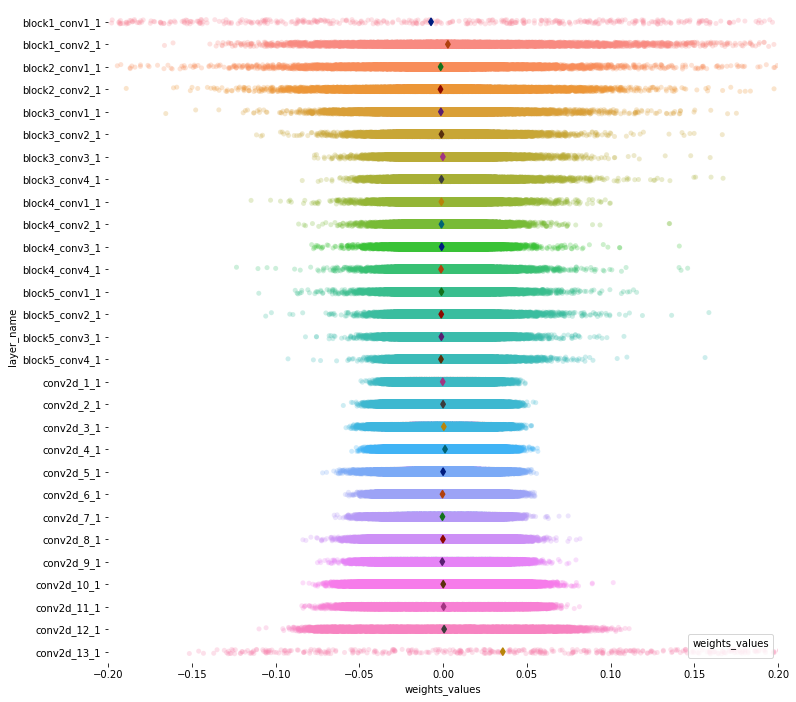

In [16]:
# Initialize the figure
f, ax = plt.subplots(figsize=(12, 12))
sns.despine(bottom=True, left=True)

tmp_df = df

# Show each observation with a scatterplot
sns.stripplot(x="weights_values", y="layer_name",
              data=tmp_df, dodge=True, jitter=True,
              alpha=.25, zorder=1)

# Show the conditional means
sns.pointplot(x="weights_values", y="layer_name",
              data=tmp_df, dodge=.532, join=False, palette="dark",
              markers="d", scale=.75, ci=None)

# Improve the legend 
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[3:], labels[3:], title="weights_values",
          handletextpad=0, columnspacing=2,
          loc="lower right", ncol=3, frameon=True)
ax.set(xlim=(-0.2, 0.2))

## Untrained Model:

#### load Model:

In [17]:
encoder_type = "vgg19"
unet = UNet()
unet.create_pretrained_model(encoder_type=encoder_type,batchnorm=False,coord_conv=False,input_shape=(512, 768, 3))
model = unet.get_model()
unet.freeze_encoder(model,encoder_type)
model = unet.get_model()

In [18]:
display_weight_stats(model)

WEIGHT NAME,SHAPE,MIN,MAX,STD
block1_conv1_2/kernel:0,"(3, 3, 3, 64)",-0.6510,+0.5509,+0.1914
block1_conv1_2/bias:0,"(64,)",-0.0124,+1.7519,+0.2951
block1_conv2_2/kernel:0,"(3, 3, 64, 64)",-0.2128,+0.2448,+0.0399
block1_conv2_2/bias:0,"(64,)",-0.9589,+0.7764,+0.3065
block2_conv1_2/kernel:0,"(3, 3, 64, 128)",-0.3375,+0.4218,+0.0300
block2_conv1_2/bias:0,"(128,)",-0.1704,+0.3515,+0.1171
block2_conv2_2/kernel:0,"(3, 3, 128, 128)",-0.1876,+0.2434,+0.0223
block2_conv2_2/bias:0,"(128,)",-0.5343,+0.6119,+0.1810
block3_conv1_2/kernel:0,"(3, 3, 128, 256)",-0.1724,+0.5945,+0.0165
block3_conv1_2/bias:0,"(256,)",-0.1734,+0.2295,+0.0646


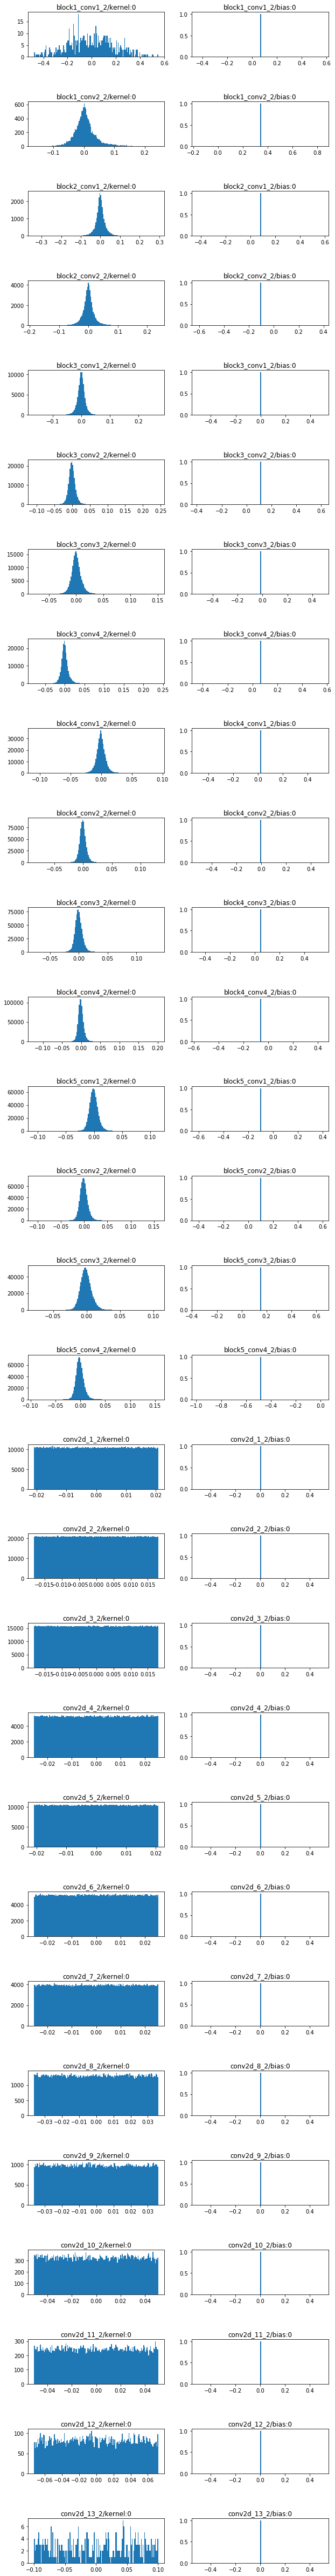

In [19]:
all_weights = []
all_names = []

# Pick layer types to display
LAYER_TYPES = ['Conv2D', 'Dense', 'Conv2DTranspose']
# Get layers
layers = model.layers
layers = list(filter(lambda l: l.__class__.__name__ in LAYER_TYPES, 
                layers))
# Display Histograms
fig, ax = plt.subplots(len(layers), 2, figsize=(10, 3*len(layers)),
                       gridspec_kw={"hspace":1})
for l, layer in enumerate(layers):
    weights = layer.get_weights()
    for w, weight in enumerate(weights):
        tensor = layer.weights[w]
        ax[l, w].set_title(tensor.name)
        _ = ax[l, w].hist(weight[w].flatten(), 150)
        if "bias" not in tensor.name:
            all_weights.append(weight[w].flatten())
            all_names.append(tensor.name[:-9])

In [20]:
df = pd.DataFrame(columns=['layer_name', 'weights_values'])
for n, w in zip(all_names,all_weights):
    if len(w) > 1:
        tmp = pd.DataFrame({"layer_name":[n for i in range(len(w.flatten()))], 
                            "weights_values":w.flatten()}) 
        df = df.append(tmp)

[(-0.2, 0.2)]

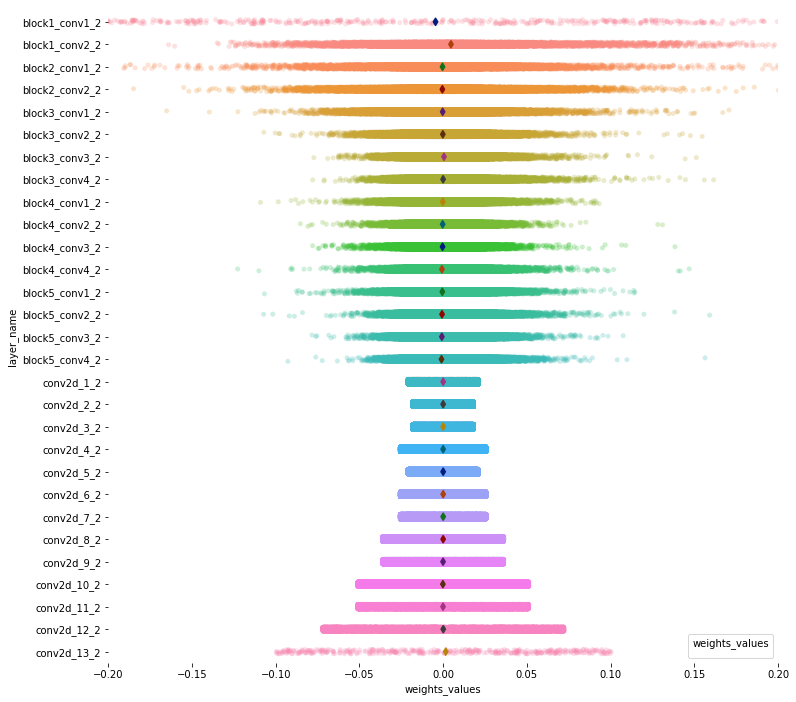

In [21]:
# Initialize the figure
f, ax = plt.subplots(figsize=(12, 12))
sns.despine(bottom=True, left=True)

tmp_df = df

# Show each observation with a scatterplot
sns.stripplot(x="weights_values", y="layer_name",
              data=tmp_df, dodge=True, jitter=True,
              alpha=.25, zorder=1)

# Show the conditional means
sns.pointplot(x="weights_values", y="layer_name",
              data=tmp_df, dodge=.532, join=False, palette="dark",
              markers="d", scale=.75, ci=None)

# Improve the legend 
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[3:], labels[3:], title="weights_values",
          handletextpad=0, columnspacing=2,
          loc="lower right", ncol=3, frameon=True)
ax.set(xlim=(-0.2, 0.2))

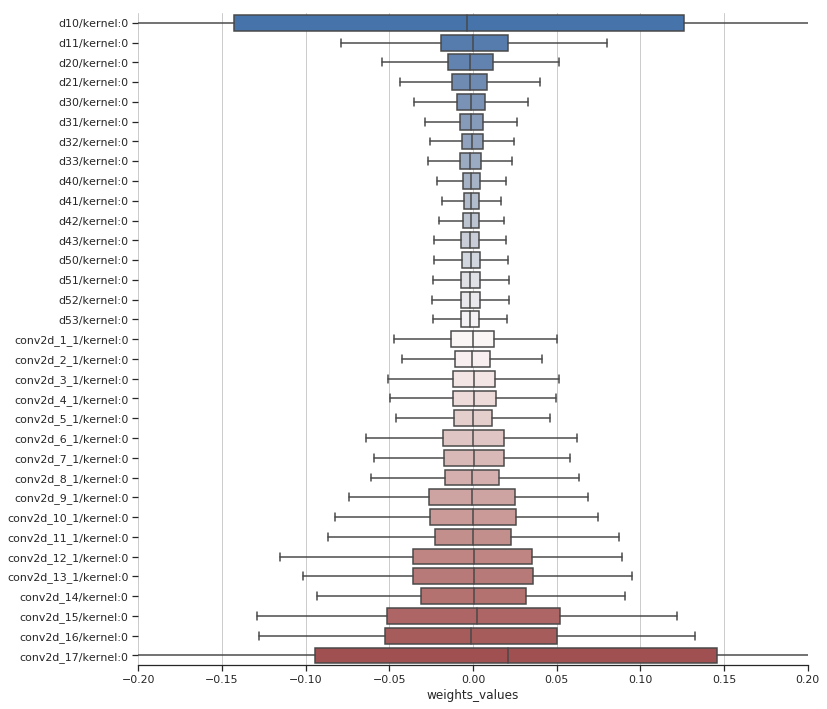

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="ticks")

# Initialize the figure with a logarithmic x axis
f, ax = plt.subplots(figsize=(12, 12))

# Plot the orbital period with horizontal boxes
sns.boxplot(x="weights_values", y="layer_name", data=df, palette="vlag", fliersize=0, notch=False)

# Add in points to show each observation
#sns.swarmplot(x="weights_values", y="layer_name", data=tmp_df,
#              size=2, color=".3", linewidth=0)

# Tweak the visual presentation
ax.xaxis.grid(True)
ax.set(ylabel="")
ax.set(xlim=(-0.2, 0.2))
sns.despine(trim=True, left=True)

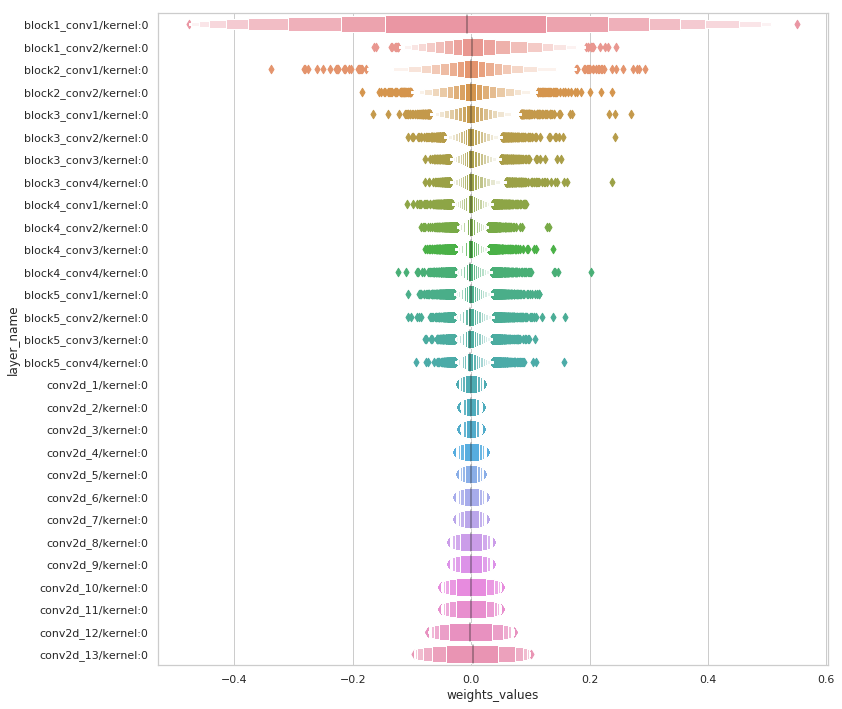

In [25]:
sns.set(style="whitegrid")

f, ax = plt.subplots(figsize=(12, 12))

sns.boxenplot(x="weights_values", y="layer_name",
              scale="linear", data=df)